# Changes from CPT v9
* Just using ICD codes
* 96.1286% accuracy
* Removing bottom least predictive words reduced model performance


# Import the MIMIC data

In [1]:
import gzip
import pandas as pd
import glob

dataset_dictionary = {}

for file_path in glob.glob('.\\Data\\MIMIC Files\*'):
    file_name = file_path.split('\\')[3].split('.')[0]
    with gzip.open(file_path, mode='r') as file:
        dataset_dictionary[file_name] = pd.read_csv(file)

c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Join the tables

In [2]:
# Create dataset to join together -----

# Create note_events table -----

def join_notes_and_icd(dataset_dictionary):
    # Combine text for each subject and encounter
    note_events_base = dataset_dictionary['NOTEEVENTS'][dataset_dictionary['NOTEEVENTS'].loc[:,'CATEGORY'] == 'Discharge summary']
    note_events = note_events_base.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False)['TEXT'].agg(sum)

    # Create ICD table -----
    icd_df = dataset_dictionary['DIAGNOSES_ICD']
    icd_df = icd_df[icd_df['SEQ_NUM'] == 1]
    icd_events_base = icd_df.loc[:, ['SUBJECT_ID','HADM_ID', 'ICD9_CODE']]
    icd_events = icd_events_base.drop_duplicates()

    # Join the datasets -----

    notes_combined = note_events.merge(icd_events, on = ['SUBJECT_ID','HADM_ID'])
    # print(note_cpt.shape, note_events.shape, cpt_events.shape) # (223,150, 4) (52,726, 3) (227,510, 3)
    
    return notes_combined

def join_notes_and_cpt(dataset_dictionary):
    # Combine text for each subject and encounter
    note_events_base = dataset_dictionary['NOTEEVENTS'][dataset_dictionary['NOTEEVENTS'].loc[:,'CATEGORY'] == 'Discharge summary']
    note_events = note_events_base.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False)['TEXT'].agg(sum)

    # Create CPT table -----

    cpt_events_base = dataset_dictionary['CPTEVENTS'].loc[:, ['SUBJECT_ID','HADM_ID', 'CPT_CD']]
    cpt_events = cpt_events_base.drop_duplicates()

    # Join the datasets -----

    notes_combined = note_events.merge(cpt_events, on = ['SUBJECT_ID','HADM_ID'])
    # print(note_cpt.shape, note_events.shape, cpt_events.shape) # (223,150, 4) (52,726, 3) (227,510, 3)
    
    return notes_combined

icd_df = join_notes_and_icd(dataset_dictionary)
# dataset_dictionary['DIAGNOSES_ICD']['SEQ_NUM']

In [1]:
dataset_dictionary['CPTEVENTS']

NameError: name 'dataset_dictionary' is not defined

# Check for Imbalance

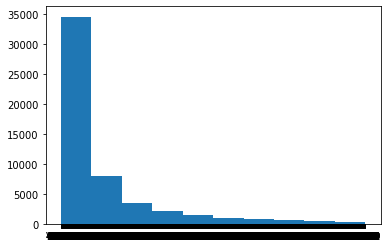

In [32]:
import matplotlib.pyplot as plt

# icd_df['ICD9_CODE'].astype(str)
x = icd_df['ICD9_CODE'].astype(str)

plt.hist(x.values)
plt.show()

# Filter to top 3 diagnosis codes

In [3]:
icd_df['ICD9_CODE'].astype(str).value_counts(ascending=False)
icd_df_3 = icd_df[icd_df['ICD9_CODE'].isin(['0389', '41071', 'V3001'])]

# Filter the data

In [4]:
import string

def clean_data(text_series):
    
    # Replace \n 
    text_series = text_series.str.replace('\\n',' ', regex=True)    

    # Remove dates and locations
    text_series = text_series.str.replace('\[\*\*(.*?)\*\*\]', ' ', regex=True)
    
    # Remove topics
    data = text_series.str.split('([A-Z\s]+:)')
    for row_num, value in enumerate(data):
        text_chunks = [x.strip().replace(':','').replace('\n', '') for x in value]
        for i, x in enumerate(text_chunks):
            if 'MEDICATION' in x or 'SOCIAL HISTORY' in x or 'FAMILY HISTORY' in x:
                text_chunks[i] = ' '
                try:
                    text_chunks[i + 1] = ' '
                except:
                    continue

        text_series.iloc[row_num] = ' '.join(text_chunks)
    
    # Replace punctuation
    text_series = text_series.str.replace('[' + string.punctuation + ']', ' ', regex=True)
    
    # Convert to lowercase 
    text_series = text_series.str.lower()
    
    # Remove all digits
    text_series = text_series.str.replace('\d',' ', regex=True)
    
    return text_series


icd_df_3_clean = clean_data(icd_df_3['TEXT'])
icd_df_3_clean

0        admission date        discharge date     date ...
13       admission date                 discharge date ...
19       admission date                 discharge date ...
25       admission date        discharge date      serv...
31       admission date        discharge date     date ...
                               ...                        
52597    admission date                 discharge date ...
52638    admission date                 discharge date ...
52644    admission date                 discharge date ...
52695    admission date                 discharge date ...
52717    admission date                 discharge date ...
Name: TEXT, Length: 5085, dtype: object

# Update text column

In [9]:
import string

icd_df_3_clean[0]

'admission date        discharge date     date of birth         sex  m  service  medicine chief complaint admitted from rehabilitation for hypotension  systolic blood pressure to the   s  and decreased urine output  history of present illness the patient is a    year old male who had been hospitalized at the   from   through   of   after undergoing a left femoral at bypass graft and was subsequently discharged to a rehabilitation facility   on    he presented again to the   after being found to have a systolic blood pressure in the   s and no urine output for    hours  a foley catheter placed at the rehabilitation facility yielded     cc of murky brown urine   there may also have been purulent discharge at the penile meatus at this time   on presentation to the emergency department  the patient was without subjective complaints   in the emergency department  he was found to have systolic blood pressure of      he was given   liters of intravenous fluids and transiently started on dopam

In [29]:
# icd_df_3.loc[:, 'TEXT'] = icd_df_3_clean.values
icd_df_3.loc[:, 'TEXT']

48376    admission date                 discharge date ...
22351    admission date                 discharge date ...
25987    admission date          discharge date     dat...
33470    admission date                 discharge date ...
29993    admission date                 discharge date ...
                               ...                        
43255    admission date                 discharge date ...
3944     admission date        discharge date     date ...
26732    admission date          discharge date    date...
33679    admission date                 discharge date ...
7467     admission date        discharge date     date ...
Name: TEXT, Length: 5085, dtype: object

# Shuffle the Data

In [6]:
icd_df_3 = icd_df_3.sample(n = len(icd_df_3), random_state = 42)

# Split the Data

In [7]:
# Import Packages -----

from nltk.corpus import stopwords

my_stop_words = list(set(stopwords.words('english'))) 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data -----

X_train, X_test, y_train, y_test = train_test_split(icd_df_3['TEXT'].values, icd_df_3['ICD9_CODE'].astype(str), test_size = .33, random_state = 42)

# Tokenize the data

In [8]:
# Tokenize the data -----

# Import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=my_stop_words, min_df = 3, max_df = .7, sublinear_tf=True)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)

# Run Naive Bayes

In [9]:
# Use Naive Bayes model -----

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB(alpha=.7)

# Fit and check accuracy
nb_classifier.fit(tfidf_train, y_train)
pred = nb_classifier.predict(tfidf_test)

# Tune NB Model

In [18]:
import numpy as np


def hyperparam_tuning(tfidf_train, y_train, tfidf_test, y_test, nb_classifier):
    for i in np.arange(0,1.1,.1):
        nb_classifier = MultinomialNB()
        nb_classifier.fit(tfidf_train, y_train)
        pred = nb_classifier.predict(tfidf_test)
        print(i)
        print(metrics.accuracy_score(y_test, pred))

hyperparam_tuning(tfidf_train, y_train, tfidf_test, y_test, nb_classifier)  

# Looks like .6-.7 are the best alpha

0.0
0.421076621541547
0.1
0.421076621541547
0.2
0.421076621541547
0.30000000000000004
0.421076621541547
0.4
0.421076621541547
0.5
0.421076621541547
0.6000000000000001
0.421076621541547
0.7000000000000001
0.421076621541547
0.8
0.421076621541547
0.9
0.421076621541547
1.0
0.421076621541547


# Run Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression

clf_logist = LogisticRegression(C=.001, random_state = 42, multi_class = 'multinomial', penalty='l2')
clf_logist.fit(tfidf_train, y_train)
logist_pred = clf_logist.predict(tfidf_test)

# Looking at Feature Names and Weights

In [52]:
# Notes
# sum([np.exp(1)** x for x in nb_classifier.coef_[0]]) # The probability of all the words equals one
# # Taken from here: * https://stackoverflow.com/questions/61586946/how-to-calculate-feature-log-prob-in-the-naive-bayes-multinomialnb

# ------------------------------------------

import numpy as np

def get_feature_rank(tfidf_vectorizer, y_no, nb_classifier):
    
    # Get the feature names
    feature_names = tfidf_vectorizer.get_feature_names()

    # Zip together the first CPT weights with feature names
    feat_with_weights =  sorted(zip(nb_classifier.coef_[y_no], feature_names))
    
    # Print words most responsible for the prediction
    print('Top 100 \n\n\n\n')
#     top_100_ls = []
    for i in range(100):
        x = feat_with_weights[-i-1]
#         top_100_ls.append(x[1])
        print(nb_classifier.classes_[y_no], i, round((np.exp(1) ** x[0]),4), x[1])

    print('\n\n\n\n Bottom 100 \n\n\n\n')
    for i in range(100):
        x = feat_with_weights[i]
        print(nb_classifier.classes_[y_no], i, round((np.exp(1) ** x[0]),4), x[1])
    
#     min_weight = min([i[0] for i in feat_with_weights])
    
    x = [i[0] for i in feat_with_weights]
    
    median_pred = np.median(x)
    min_pred = min(x)
          
    return [i[1] for i in feat_with_weights if i[0] == min_pred] # Minimum weight words
#     return top_100_ls

# Find the least predictive words
def least_pred_words(nb_classifier, tfidf_vectorizer):
    low_wt_stop_ls = []

    for i in range(len(nb_classifier.classes_)):
        low_wt_stop_ls += get_feature_rank(tfidf_vectorizer, i, nb_classifier)

    low_wt_stop_ls = list(set(low_wt_stop_ls))
    return low_wt_stop_ls
    

# Find top 100 words - doesn't seem to improve the model
def highest_pred_words(nb_classifier, tfidf_vectorizer):
    top_100_ls = []
    for i in range(len(nb_classifier.classes_)):
        top_100_ls += get_feature_rank(tfidf_vectorizer, i, nb_classifier)

    top_100_ls = list(set(top_100_ls))
    return top_100_ls

# low_wt_stop_ls = least_pred_words(nb_classifier, tfidf_vectorizer)
get_feature_rank(tfidf_vectorizer, 2, nb_classifier)

Top 100 




V3001 0 0.0037 infant
V3001 1 0.0029 life
V3001 2 0.0022 delivery
V3001 3 0.0021 born
V3001 4 0.0021 newborn
V3001 5 0.0021 age
V3001 6 0.0019 baby
V3001 7 0.0019 percentile
V3001 8 0.0018 respiratory
V3001 9 0.0018 prematurity
V3001 10 0.0018 mother
V3001 11 0.0018 hepatitis
V3001 12 0.0017 weight
V3001 13 0.0017 immunizations
V3001 14 0.0017 gestation
V3001 15 0.0017 th
V3001 16 0.0017 feeding
V3001 17 0.0016 screening
V3001 18 0.0016 pregnancy
V3001 19 0.0016 breast
V3001 20 0.0016 pediatrician
V3001 21 0.0016 infants
V3001 22 0.0016 screen
V3001 23 0.0016 weeks
V3001 24 0.0015 kg
V3001 25 0.0015 cardiovascular
V3001 26 0.0015 section
V3001 27 0.0015 prenatal
V3001 28 0.0015 immunization
V3001 29 0.0015 bilirubin
V3001 30 0.0015 electrolytes
V3001 31 0.0015 cm
V3001 32 0.0015 room
V3001 33 0.0015 lib
V3001 34 0.0015 ad
V3001 35 0.0015 air
V3001 36 0.0015 murmur
V3001 37 0.0014 gestational
V3001 38 0.0014 examination
V3001 39 0.0014 neonatal
V3001 40 0.0014 head
V3001 41

['aa',
 'aaa',
 'aado',
 'aao',
 'aaox',
 'abacavir',
 'abate',
 'abated',
 'abbreviated',
 'abcess',
 'abciximab',
 'abdm',
 'abdom',
 'abdomensoft',
 'abdominial',
 'abdsoft',
 'abgs',
 'abi',
 'abis',
 'abnl',
 'abnls',
 'abodminal',
 'abominal',
 'abrasions',
 'abrupt',
 'abruptly',
 'abscence',
 'absorption',
 'abstinent',
 'abutting',
 'acalculous',
 'acantho',
 'acanthocy',
 'acapella',
 'acc',
 'accelerated',
 'accelerating',
 'accentuated',
 'accessed',
 'accessible',
 'accessing',
 'accessory',
 'accidentally',
 'accidents',
 'accompanies',
 'account',
 'accounting',
 'accumulating',
 'accupril',
 'accurately',
 'accuzyme',
 'acei',
 'acet',
 'acetazolamide',
 'acetmnp',
 'acetmnphn',
 'acetominophen',
 'acetonide',
 'acetylcysteine',
 'ach',
 'achalasia',
 'ache',
 'aches',
 'aching',
 'achs',
 'achy',
 'acidemic',
 'acidophilus',
 'aciphex',
 'acknowledged',
 'acl',
 'acls',
 'acne',
 'acove',
 'acquire',
 'acromioclavicular',
 'acs',
 'act',
 'acth',
 'actinic',
 'action',

# Update stop words and tokenize again

In [60]:
my_stop_words += low_wt_stop_ls

tfidf_vectorizer = TfidfVectorizer(stop_words=my_stop_words, min_df = 3, max_df = .7, sublinear_tf=True)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)


# Create Vocab with top words and tokenize again

In [ ]:
# It reduced test accuracy back to 43% and training went from 50% to 44%

tfidf_vectorizer = TfidfVectorizer(vocabulary=top_100_ls, stop_words=my_stop_words, min_df = 3, max_df = .7, sublinear_tf=True)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)


# Run Naive Bayes again

In [61]:
# Use Naive Bayes model -----

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB(alpha=.7)

# Fit and check accuracy
nb_classifier.fit(tfidf_train, y_train)
pred = nb_classifier.predict(tfidf_test)

# Classification Report

In [10]:
# Create classification report taken from here: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
from sklearn.metrics import classification_report

print('Test')
class_labels = nb_classifier.classes_
print(classification_report(y_test, pred,target_names=class_labels))

print('Training')
pred_x = nb_classifier.predict(tfidf_train)
print(classification_report(y_train, pred_x,target_names=class_labels))


Test
              precision    recall  f1-score   support

        0389       0.92      0.97      0.95       622
       41071       0.97      0.92      0.94       589
       V3001       1.00      1.00      1.00       468

    accuracy                           0.96      1679
   macro avg       0.96      0.96      0.96      1679
weighted avg       0.96      0.96      0.96      1679

Training
              precision    recall  f1-score   support

        0389       0.94      0.99      0.96      1354
       41071       0.98      0.92      0.95      1130
       V3001       1.00      1.00      1.00       922

    accuracy                           0.97      3406
   macro avg       0.97      0.97      0.97      3406
weighted avg       0.97      0.97      0.97      3406



In [36]:
metrics.accuracy_score(y_test, pred)

# """
# V1 NLP Model Accuracy: 0.117
# Wow, I've got a long way to go to improve accuracy
# V2 NLP Model Accuracy: 0.14
# V3 NLP Model Accuracy: .40
# """

# Confusion matrix 
# confusion_mtrx = metrics.confusion_matrix(y_test.astype(str), pred) # 1380, 1380
# confusion_mtrx

0.9612864800476474

In [47]:
# Logistical Model accuracy
metrics.accuracy_score(y_test, logist_pred)
# .39



0.40142942227516376

# Vectorize Test

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

vocab = ['love', 'happy', 'run']
count_vectorizer = CountVectorizer(vocabulary = vocab)
x = count_vectorizer.fit_transform(['happy', 'run', 'run', 'run'])
print(x)

  (0, 1)	1
  (1, 2)	1
  (2, 2)	1
  (3, 2)	1


# Predict Based on Input

In [13]:
def predict_icd(text):
    input_text_clean = clean_data(pd.Series(text))
    tfidf_input_test = tfidf_vectorizer.transform(input_text_clean)
#     print(nb_classifier.predict(tfidf_input_test)[0]  )
    print(nb_classifier.predict(tfidf_input_test)[0], str(round(max(nb_classifier.predict_proba(tfidf_input_test)[0]) * 100,2)) + '%')
    
# Source: https://www.mayoclinic.org/diseases-conditions/sepsis/symptoms-causes/syc-20351214?utm_source=Google&utm_medium=abstract&utm_content=Sepsis&utm_campaign=Knowledge-panel
# 0389
text_0389 = ['Sepsis occurs when chemicals released in the bloodstream to fight an infection trigger \
              inflammation throughout the body. This can cause a cascade of changes that damage multiple organ systems, \
              causing them to fail, sometimes even resulting in death.\
            Symptoms include fever, difficulty breathing, low blood pressure, fast heart rate, and mental confusion.\
            Treatment includes antibiotics and intravenous fluids.']


# 41071
# https://www.mayoclinic.org/diseases-conditions/myocardial-ischemia/symptoms-causes/syc-20375417

text_41071 = """
Myocardial ischemia occurs when blood flow to your heart is reduced, preventing the heart muscle from receiving enough oxygen. The reduced blood flow is usually the result of a partial or complete blockage of your heart's arteries (coronary arteries).
Myocardial ischemia, also called cardiac ischemia, reduces the heart muscle's ability to pump blood. A sudden, severe blockage of one of the heart's artery can lead to a heart attack. Myocardial ischemia might also cause serious abnormal heart rhythms.
Treatment for myocardial ischemia involves improving blood flow to the heart muscle. Treatment may include medications, a procedure to open blocked arteries (angioplasty) or bypass surgery.
Making heart-healthy lifestyle choices is important in treating and preventing myocardial ischemia.
"""

# V3001
# https://www.mayoclinic.org/healthy-lifestyle/labor-and-delivery/basics/labor-and-delivery/hlv-20049465
text_V3001 = """
Every woman's labor and delivery experience is unique. Still, understanding what's typical can help you know what to expect as your due date approaches.
Labor and delivery generally follows a pattern — the cervix softening and opening; the amniotic sac rupturing; the contractions getting stronger and closer together. Sometimes, however, labor and delivery takes surprising twists and turns. You might reconsider your wishes about pain medication, or you might need an unexpected C-section.
However your labor and delivery unfolds, remember that your health and your baby's health are what's most important. Discuss your labor and delivery preferences with your health care provider, including options for pain medication and thoughts about episiotomy and other procedures. Then look forward to welcoming your baby into the world.
"""

predict_icd(text_V3001)

V3001 65.01%
